In [1]:
import numpy as np
import time
import random

import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable

from graphsage.model import *

from sklearn.metrics import f1_score

from cora.load_cora import load_cora

In [2]:
# init
num_nodes = 2708
embedd_dim = 128
batch_size = 256

# load data
feat_data, labels, adj_lists = load_cora()

In [3]:
features = nn.Embedding(num_nodes, 1433)
features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)

agg1 = MeanAggregator(features, cuda=True)
enc1 = Encoder(features, 1433, embedd_dim, adj_lists, agg1, gcn=True, cuda=False)

agg2 = MeanAggregator(lambda nodes : enc1(nodes).t(), cuda=False)
enc2 = Encoder(lambda nodes : enc1(nodes).t(), enc1.embed_dim, embedd_dim, adj_lists, agg2,
        base_model=enc1, gcn=True, cuda=False)

enc1.num_samples = 5
enc2.num_samples = 5
graphsage = SupervisedGraphSage(7, enc2)

rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:1000]
val = rand_indices[1000:1500]
train = list(rand_indices[1500:])

optimizer = torch.optim.SGD(filter(lambda p : p.requires_grad, graphsage.parameters()), lr=0.7)
times = []
for batch in range(100):
    random.shuffle(train)
    batch_nodes = train[:batch_size]
    start_time = time.time()
    optimizer.zero_grad()
    loss = graphsage.loss(batch_nodes, 
            Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
    loss.backward()
    optimizer.step()
    end_time = time.time()
    times.append(end_time-start_time)
    if batch % 10 == 0:
        print (batch, loss.data[0])
        test_output = graphsage.forward(test) 
        print ("Test F1:", f1_score(labels[test], test_output.data.numpy().argmax(axis=1), average="micro"))

/home/denis/GitHub/knowledge-graph-base/tests/graphsage/graphsage/model.py:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(self.weight)
/home/denis/GitHub/knowledge-graph-base/tests/graphsage/graphsage/model.py:118: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(self.weight)
/home/denis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


0 tensor(1.9367)
Test F1: 0.301
10 tensor(1.6103)
Test F1: 0.328
20 tensor(1.1260)
Test F1: 0.706
30 tensor(0.5719)
Test F1: 0.825
40 tensor(0.4835)
Test F1: 0.83
50 tensor(0.3627)
Test F1: 0.847
60 tensor(0.2824)
Test F1: 0.857
70 tensor(0.2231)
Test F1: 0.855
80 tensor(0.7964)
Test F1: 0.703
90 tensor(0.2376)
Test F1: 0.851


In [4]:
print(graphsage.get_embeds(test).shape, labels[np.array(test)].shape)
val_output = graphsage.forward(val) 
print ("Validation F1:", f1_score(labels[val], val_output.data.numpy().argmax(axis=1), average="micro"))
print ("Average batch time:", np.mean(times))

torch.Size([128, 1000]) (1000, 1)
Validation F1: 0.842
Average batch time: 0.022435612678527832


In [5]:
embeds = graphsage.get_embeds(rand_indices).data.cpu().numpy()

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

In [9]:
proj = KMeans(np.max(labels)).fit_transform(embeds.T)

True number of clusters is 6


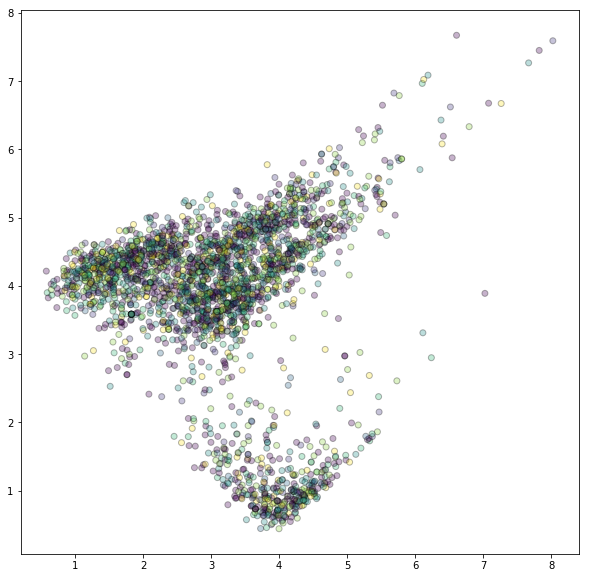

In [10]:
print("True number of clusters is {}".format(np.max(labels)))
plt.figure(figsize=(10, 10))
plt.scatter(proj[:,1], proj[:,0], c=labels.ravel(), alpha=0.3, edgecolor='k')
plt.show()